# Models for Project 4

#### Importing data and packages that will be used for analysis

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
%matplotlib inline 

#### Load dataset and save as 'wine' variable
After importing all dependencies we load our dataset called wine.

In [2]:
wine = pd.read_json('./wine-reviews/winemag-data-130k-v2.json', dtype='unicode');

In [3]:
wine.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,nan,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,None,Alexander Peartree,None,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
wine.isnull().sum()

country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64

In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129971 non-null object
description              129971 non-null object
designation              129971 non-null object
points                   129971 non-null object
price                    129971 non-null object
province                 129971 non-null object
region_1                 129971 non-null object
region_2                 129971 non-null object
taster_name              129971 non-null object
taster_twitter_handle    129971 non-null object
title                    129971 non-null object
variety                  129971 non-null object
winery                   129971 non-null object
dtypes: object(13)
memory usage: 12.9+ MB


In [6]:
#changing dtypes for points and price
wine['points'] = wine.points.astype(int)
wine['price'] = wine.price.astype(float)
wine.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,None,Alexander Peartree,None,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
#Since the wine price is an object with 'nan' text values 
#I needed to find a way to remove the values without using dropna.
wine.dropna(inplace=True)

In [13]:
dummy = pd.get_dummies(wine[['country']],prefix='dum_country', drop_first=True)
print(dummy.columns)

Index(['dum_country_Armenia', 'dum_country_Australia', 'dum_country_Austria',
       'dum_country_Bosnia and Herzegovina', 'dum_country_Brazil',
       'dum_country_Bulgaria', 'dum_country_Canada', 'dum_country_Chile',
       'dum_country_China', 'dum_country_Croatia', 'dum_country_Cyprus',
       'dum_country_Czech Republic', 'dum_country_England',
       'dum_country_France', 'dum_country_Georgia', 'dum_country_Germany',
       'dum_country_Greece', 'dum_country_Hungary', 'dum_country_India',
       'dum_country_Israel', 'dum_country_Italy', 'dum_country_Lebanon',
       'dum_country_Luxembourg', 'dum_country_Macedonia', 'dum_country_Mexico',
       'dum_country_Moldova', 'dum_country_Morocco', 'dum_country_New Zealand',
       'dum_country_None', 'dum_country_Peru', 'dum_country_Portugal',
       'dum_country_Romania', 'dum_country_Serbia', 'dum_country_Slovakia',
       'dum_country_Slovenia', 'dum_country_South Africa', 'dum_country_Spain',
       'dum_country_Switzerland', 'dum_c

In [14]:
dummy = pd.get_dummies(wine[['designation']],prefix='dum_designation', drop_first=True)
print(dummy.columns)

Index(['dum_designation_#50 Mon Chou', 'dum_designation_#SocialSecret',
       'dum_designation_%@#$!', 'dum_designation_&',
       'dum_designation_'61 Rosé', 'dum_designation_'A Rina',
       'dum_designation_'Blend 105' Red Wine', 'dum_designation_'Na Vota',
       'dum_designation_'S'', 'dum_designation_'Unfiltered'',
       ...
       'dum_designation_Ürziger Würzgarten GG Réserve Alte Reben Erste Lage Dry',
       'dum_designation_Ürziger Würzgarten Kabinett',
       'dum_designation_Ürziger Würzgarten Spätlese',
       'dum_designation_étoile Brut', 'dum_designation_étoile Rosé',
       'dum_designation_Župska', 'dum_designation_‘Rough Justice' Red',
       'dum_designation_‘S'', 'dum_designation_“Champ” Jim the Gent',
       'dum_designation_“Champ” Lightnin' Lane'],
      dtype='object', length=35776)


In [15]:
dummy = pd.get_dummies(wine[['province']],prefix='dum_province', drop_first=True)
print(dummy.columns)

Index(['dum_province_Aconcagua Costa', 'dum_province_Aconcagua Valley',
       'dum_province_Aegean', 'dum_province_Agioritikos', 'dum_province_Ahr',
       'dum_province_Alenquer', 'dum_province_Alentejano',
       'dum_province_Alentejo', 'dum_province_Alenteo', 'dum_province_Algarve',
       ...
       'dum_province_Wellington', 'dum_province_Western Australia',
       'dum_province_Western Cape', 'dum_province_Wiener Gemischter Satz',
       'dum_province_Württemberg', 'dum_province_Zenata',
       'dum_province_Österreichischer Perlwein',
       'dum_province_Österreichischer Sekt', 'dum_province_Štajerska',
       'dum_province_Župa'],
      dtype='object', length=422)


In [16]:
dummy = pd.get_dummies(wine[['region_1']],prefix='dum_region_1', drop_first=True)
print(dummy.columns)

Index(['dum_region_1_Adelaida District', 'dum_region_1_Adelaide',
       'dum_region_1_Adelaide Hills', 'dum_region_1_Adelaide Plains',
       'dum_region_1_Aglianico d'Irpinia',
       'dum_region_1_Aglianico del Beneventano',
       'dum_region_1_Aglianico del Taburno',
       'dum_region_1_Aglianico del Vulture', 'dum_region_1_Agrelo',
       'dum_region_1_Albana di Romagna',
       ...
       'dum_region_1_Yadkin Valley', 'dum_region_1_Yakima Valley',
       'dum_region_1_Yamhill County', 'dum_region_1_Yarra Valley',
       'dum_region_1_Yecla', 'dum_region_1_Yolo County',
       'dum_region_1_York Mountain', 'dum_region_1_Yorkville Highlands',
       'dum_region_1_Yountville', 'dum_region_1_Zonda Valley'],
      dtype='object', length=1204)


In [17]:
dummy = pd.get_dummies(wine[['region_2']],prefix='dum_region_2', drop_first=True)
print(dummy.columns)

Index(['dum_region_2_Central Coast', 'dum_region_2_Central Valley',
       'dum_region_2_Columbia Valley', 'dum_region_2_Finger Lakes',
       'dum_region_2_Long Island', 'dum_region_2_Napa',
       'dum_region_2_Napa-Sonoma', 'dum_region_2_New York Other',
       'dum_region_2_None', 'dum_region_2_North Coast',
       'dum_region_2_Oregon Other', 'dum_region_2_Sierra Foothills',
       'dum_region_2_Sonoma', 'dum_region_2_South Coast',
       'dum_region_2_Southern Oregon', 'dum_region_2_Washington Other',
       'dum_region_2_Willamette Valley'],
      dtype='object')


In [19]:
dummy = pd.get_dummies(wine[['variety']],prefix='dum_variety', drop_first=True)
print(dummy.columns)
dummy.shape

Index(['dum_variety_Agiorgitiko', 'dum_variety_Aglianico',
       'dum_variety_Aidani', 'dum_variety_Airen', 'dum_variety_Albana',
       'dum_variety_Albanello', 'dum_variety_Albariño',
       'dum_variety_Albarossa', 'dum_variety_Aleatico',
       'dum_variety_Alfrocheiro',
       ...
       'dum_variety_Xynisteri', 'dum_variety_Yapincak', 'dum_variety_Zibibbo',
       'dum_variety_Zierfandler', 'dum_variety_Zierfandler-Rotgipfler',
       'dum_variety_Zinfandel', 'dum_variety_Zlahtina', 'dum_variety_Zweigelt',
       'dum_variety_Çalkarası', 'dum_variety_Žilavka'],
      dtype='object', length=697)


(120975, 697)

In [20]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
dummy_wine = pd.concat([wine, dummy], axis=1)

# Print five random rows.
dummy_wine.sample(n=5, random_state=1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,dum_variety_Xynisteri,dum_variety_Yapincak,dum_variety_Zibibbo,dum_variety_Zierfandler,dum_variety_Zierfandler-Rotgipfler,dum_variety_Zinfandel,dum_variety_Zlahtina,dum_variety_Zweigelt,dum_variety_Çalkarası,dum_variety_Žilavka
60622,US,"Lots of blackberry, plum, currant and oak flav...",Deux Chevaux Vineyard Rabicano,87,53.0,California,Yountville,Napa,None,None,...,0,0,0,0,0,0,0,0,0,0
28866,Italy,This sparkler from Piedmont opens with aromas ...,Metodo Classico,86,30.0,Piedmont,Roero,None,Kerin O’Keefe,@kerinokeefe,...,0,0,0,0,0,0,0,0,0,0
49187,US,The question is whether you should drink it no...,Felicity,92,60.0,California,Coombsville,Napa,None,None,...,0,0,0,0,0,0,0,0,0,0
60997,Spain,Raisin and earth aromas come across a bit bake...,Crianza,87,18.0,Northern Spain,Rioja,None,Michael Schachner,@wineschach,...,0,0,0,0,0,0,0,0,0,0
5676,US,"This crisp, coastal wine was fermented in half...",None,90,22.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,...,0,0,0,0,0,0,0,0,0,0


In [21]:
dummy_wine.isnull().sum()

country                                0
description                            0
designation                            0
points                                 0
price                                  0
province                               0
region_1                               0
region_2                               0
taster_name                            0
taster_twitter_handle                  0
title                                  0
variety                                0
winery                                 0
dum_variety_Agiorgitiko                0
dum_variety_Aglianico                  0
dum_variety_Aidani                     0
dum_variety_Airen                      0
dum_variety_Albana                     0
dum_variety_Albanello                  0
dum_variety_Albariño                   0
dum_variety_Albarossa                  0
dum_variety_Aleatico                   0
dum_variety_Alfrocheiro                0
dum_variety_Alicante                   0
dum_variety_Alic

#### Trying Linear Regression

In [34]:
X = dummy
y = wine['points']

linreg = linear_model.LinearRegression()
linreg.fit(X,y)

print(linreg.score(X,y))

0.09695061768857804


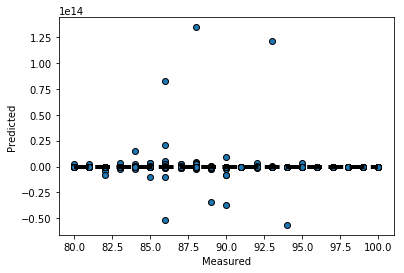

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

linreg.fit(X_train,y_train)



predicted = cross_val_predict(linreg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print(linreg.score(X,y))

In [29]:
#linear regression with price feature only

features = ['price']


X_wine = wine[features]                # used to make prediction                                                    
y_wine = wine['points']                          # what we want to predict 

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, random_state = 413)

# train data is what the model is fed
# testing data is new and shows how well the model can adjust
linreg = LinearRegression()
linreg.fit(X_train_wine, y_train_wine)
    
y_pred_wine = linreg.predict(X_test_wine)

print("Points value if all X variables were ZERO",linreg.intercept_) # print the interecept and the slope coeffecient
print("R-sq", linreg.score(X_wine,y_wine)) #output the score or the rsqared of the model
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test_wine, y_pred_wine)))  #spit out RMSE

list(zip(features, linreg.coef_))

Points value if all X variables were ZERO 87.37127353791841
R-sq 0.1729419040540281
RMSE 2.7448290922077474


[('price', 0.029706128437876737)]

In [31]:
#linear regression with dummy features
features = ['col for col in wine.columns if 'dum_country' in col']


X_wine = wine[features]                # used to make prediction                                                    
y_wine = wine['points']                          # what we want to predict 

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, random_state = 413)

# train data is what the model is fed
# testing data is new and shows how well the model can adjust
linreg = LinearRegression()
linreg.fit(X_train_wine, y_train_wine)
    
y_pred_wine = linreg.predict(X_test_wine)

print("Points value if all X variables were ZERO",linreg.intercept_) # print the interecept and the slope coeffecient
print("R-sq", linreg.score(X_wine,y_wine)) #output the score or the rsqared of the model
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test_wine, y_pred_wine)))  #spit out RMSE

list(zip(features, linreg.coef_))

SyntaxError: invalid syntax (<ipython-input-31-cf8f2b84e141>, line 2)